In [0]:
#from google.colab import drive
#drive.mount('/content/drive')



In [0]:
!pip install pydensecrf
!pip install -U cython


     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153733 sha256=abde0f279633d43843d17a73fdd4f8607b0d418b322d61f96161a8fc5e41b620
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)


In [0]:
!wget http://umnlcc.cs.umn.edu/Datasets/River_Fragments.zip
#!rsync -avz /content/drive/My\ Drive/Courses/Fall\ 2019/AI\ for\ earth/River_Fragments.zip .
!unzip /content/River_Fragments.zip
!mkdir DeepWaterMap
!mkdir crf



#from google.colab import files
#files.download('/content/drive/My Drive/Courses/Fall 2019/River')
!rm -rf /content/__MACOSX
!ls River/label | wc -l
#!ls DeepWaterMap | wc -l

--2019-12-11 01:03:10--  http://umnlcc.cs.umn.edu/Datasets/River_Fragments.zip
Resolving umnlcc.cs.umn.edu (umnlcc.cs.umn.edu)... 128.101.106.34
Connecting to umnlcc.cs.umn.edu (umnlcc.cs.umn.edu)|128.101.106.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2028778142 (1.9G) [application/zip]
Saving to: ‘River_Fragments.zip’

River_Fragments.zip 100%[===================>]   1.89G  74.3MB/s    in 26s     

2019-12-11 01:03:36 (73.2 MB/s) - ‘River_Fragments.zip’ saved [2028778142/2028778142]

Archive:  /content/River_Fragments.zip
   creating: River/
  inflating: River/Auto-Encoder.py   
  inflating: River/CNN.py            
   creating: River/data/
  inflating: River/data/0.npy        
  inflating: River/data/1.npy        
  inflating: River/data/10.npy       
  inflating: River/data/100.npy      
  inflating: River/data/1000.npy     
  inflating: River/data/10000.npy    
  inflating: River/data/10001.npy    
  inflating: River/data/10002.npy    
  inflating: 

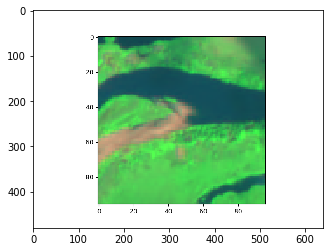

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

vis_path='River/visualization/0.png'
img=mpimg.imread(vis_path)

imgplot = plt.imshow(img)
plt.show()



## Baseline U-Net model

In [0]:
from keras.models import Model
from keras.layers import Dropout, Input,Dense, Activation, Conv2D, InputLayer, Concatenate, MaxPooling2D, concatenate, BatchNormalization, UpSampling2D, Conv2DTranspose, Flatten, Reshape, Convolution2D, Permute
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import keras

def unet_label(pretrained_weights = None,input_size = (96,96,9)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_1')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),name='layer_3')(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_4')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_5')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),name='layer_6')(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_7')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_8')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),name='layer_9')(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_10')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_11')(conv4)
    drop4 = Dropout(0.5,name='layer_12')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),name='layer_13')(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_14')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='layer_15')(conv5)
    drop5 = Dropout(0.5,name='layer_16')(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_1')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3,name='Llayer_2')
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_3')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_4')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_5')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3,name='Llayer_6')
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_7')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_8')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_9')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3,name='Llayer_10')
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_11')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_12')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_13')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3,name='Llayer_14')
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_15')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_16')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='Llayer_17')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid',name='Llayer_18')(conv9)

    model = Model(input = inputs, output = conv10)


    if(pretrained_weights):
        model.load_weights(pretrained_weights, by_name=True)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
  
unet_label()

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("Ll...)`


In [0]:

import keras.backend as K

def customLoss(yTrue,yPred):
  
  ylogy=K.log(yPred)
  ylogy=yTrue*ylogy
  #ylogy=ylogy
  
  comp_yTrue=1-yTrue
  comp_y=K.log(1-yPred)

  comp_ylogy=comp_yTrue*comp_y
  #comp_ylogy=comp_ylogy

  loss = ylogy + comp_ylogy
  loss=-loss

  loss=K.pool2d(pool_size=(7,7),x=loss)

  flat=K.flatten(loss)
  res=K.mean(loss)

  return res


def pool_loss_5():

  input_layer=Input(shape=(96,96,9))
  
  conv_1=Conv2D(name='conv_1',filters=5,kernel_size=5,padding='same')(input_layer)
  bnorm_1=BatchNormalization(name='bnorm_1')(conv_1)
  act_1=Activation(name='act_1',activation='relu')(bnorm_1)

  pool_1=MaxPooling2D(name='pool_1')(act_1)



  conv_2=Conv2D(name='conv_2',filters=3,kernel_size=5,padding='same')(pool_1)
  bnorm_2=BatchNormalization(name='bnorm_2')(conv_2)
  act_2=Activation(name='act_2',activation='relu')(bnorm_2)

  conc_2 = Concatenate(axis=-1, name='conc_2')([pool_1,act_2])

  pool_2=MaxPooling2D(name='pool_2')(conc_2)



  conv_3=Conv2D(name='conv_3',filters=2,kernel_size=1)(pool_2)
  bnorm_3=BatchNormalization(name='bnorm_3')(conv_3)
  act_3=Activation(activation='relu')(bnorm_3)

  conc_3=Concatenate(axis=-1, name='conc_3')([pool_2,act_3])
  pool_3=MaxPooling2D(name='pool_3')(conc_3)




  conv_4=Conv2D(name='conv_4',filters=2,kernel_size=1)(pool_3)
  bnorm_4=BatchNormalization(name='bnorm_4')(conv_4)
  act_4=Activation(activation='relu')(bnorm_4)

  conc_4=Concatenate(axis=-1, name='conc_4')([pool_3,act_4])
  pool_4=MaxPooling2D(name='pool_4')(conc_4)



  conv_5=Conv2D(name='conv_5',filters=2,kernel_size=1)(pool_4)
  bnorm_5=BatchNormalization(name='bnorm_5')(conv_5)
  act_5=Activation(activation='relu')(bnorm_5)

  conc_5=Concatenate(axis=-1, name='conc_5')([pool_4,act_5])
  pool_5=MaxPooling2D(name='pool_5')(conc_5)

  
  
  ## DECODE
  
  upsamp_1=UpSampling2D()(pool_5)
  dconc_1=Concatenate(axis=-1, name='donc_1')([upsamp_1,conc_5])

  
  convt_1=Conv2DTranspose(filters=2,kernel_size=1)(dconc_1)
  dnorm1=BatchNormalization()(convt_1)
  dact_1=Activation(activation='relu')(dnorm1)

  upsamp_2=UpSampling2D()(dact_1)
  dconc_2=Concatenate(axis=-1, name='donc_2')([upsamp_2,conc_4])

  convt_2=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_2)
  dnorm_2=BatchNormalization()(convt_2)
  dact_2=Activation(activation='relu')(dnorm_2)


  upsamp_3=UpSampling2D()(dact_2)
  dconc_3=Concatenate(axis=-1, name='donc_3')([upsamp_3,conc_3])

  convt_3=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_3)
  dnorm_3=BatchNormalization()(convt_3)
  dact_3=Activation(activation='relu')(dnorm_3)



  upsamp_4=UpSampling2D()(dact_3)
  dconc_4=Concatenate(axis=-1, name='donc_4')([upsamp_4,conc_2])

  convt_4=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_4)
  dnorm_4=BatchNormalization()(convt_4)
  dact_4=Activation(activation='relu')(dnorm_4)



  upsamp_5=UpSampling2D()(dact_4)
  dconc_5=Concatenate(axis=-1, name='donc_5')([upsamp_5,act_1])

  convt_5=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_5)
  dnorm_5=BatchNormalization()(convt_5)
  dact_5=Activation(activation='relu')(dnorm_5)


  conv_last=Conv2D(filters=1,kernel_size=1)(dact_5)
  #flat=Flatten()(conv_last)
  act_3=Activation(activation='sigmoid')(conv_last)


  model=Model(inputs=input_layer,outputs=act_3)

  model.compile(loss=customLoss, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

  print(model.summary())
  return model

pool_loss_5()









Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 9)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 96, 96, 5)    1130        input_2[0][0]                    
__________________________________________________________________________________________________
bnorm_1 (BatchNormalization)    (None, 96, 96, 5)    20          conv_1[0][0]                     
__________________________________________________________________________________________________
act_1 (Activation)              (None, 96, 96, 5)    0           bnorm_1[0][0]                    
_____________________________________________________________________________________

## DeepWater model code

In [0]:
from keras.models import Model
from keras.layers import Input,Dense, Activation, Conv2D, InputLayer, Concatenate, MaxPooling2D, concatenate, BatchNormalization, UpSampling2D, Conv2DTranspose, Flatten, Reshape, Convolution2D, Permute
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import keras


def deepwater_5():
  input_layer=Input(shape=(96,96,9))
  
  conv_1=Conv2D(name='conv_1',filters=5,kernel_size=5,padding='same')(input_layer)
  bnorm_1=BatchNormalization(name='bnorm_1')(conv_1)
  act_1=Activation(name='act_1',activation='relu')(bnorm_1)

  pool_1=MaxPooling2D(name='pool_1')(act_1)



  conv_2=Conv2D(name='conv_2',filters=3,kernel_size=5,padding='same')(pool_1)
  bnorm_2=BatchNormalization(name='bnorm_2')(conv_2)
  act_2=Activation(name='act_2',activation='relu')(bnorm_2)

  conc_2 = Concatenate(axis=-1, name='conc_2')([pool_1,act_2])

  pool_2=MaxPooling2D(name='pool_2')(conc_2)



  conv_3=Conv2D(name='conv_3',filters=2,kernel_size=1)(pool_2)
  bnorm_3=BatchNormalization(name='bnorm_3')(conv_3)
  act_3=Activation(activation='relu')(bnorm_3)

  conc_3=Concatenate(axis=-1, name='conc_3')([pool_2,act_3])
  pool_3=MaxPooling2D(name='pool_3')(conc_3)




  conv_4=Conv2D(name='conv_4',filters=2,kernel_size=1)(pool_3)
  bnorm_4=BatchNormalization(name='bnorm_4')(conv_4)
  act_4=Activation(activation='relu')(bnorm_4)

  conc_4=Concatenate(axis=-1, name='conc_4')([pool_3,act_4])
  pool_4=MaxPooling2D(name='pool_4')(conc_4)



  conv_5=Conv2D(name='conv_5',filters=2,kernel_size=1)(pool_4)
  bnorm_5=BatchNormalization(name='bnorm_5')(conv_5)
  act_5=Activation(activation='relu')(bnorm_5)

  conc_5=Concatenate(axis=-1, name='conc_5')([pool_4,act_5])
  pool_5=MaxPooling2D(name='pool_5')(conc_5)

  
  
  ## DECODE
  
  upsamp_1=UpSampling2D()(pool_5)
  dconc_1=Concatenate(axis=-1, name='donc_1')([upsamp_1,conc_5])

  
  convt_1=Conv2DTranspose(filters=2,kernel_size=1)(dconc_1)
  dnorm1=BatchNormalization()(convt_1)
  dact_1=Activation(activation='relu')(dnorm1)

  upsamp_2=UpSampling2D()(dact_1)
  dconc_2=Concatenate(axis=-1, name='donc_2')([upsamp_2,conc_4])

  convt_2=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_2)
  dnorm_2=BatchNormalization()(convt_2)
  dact_2=Activation(activation='relu')(dnorm_2)


  upsamp_3=UpSampling2D()(dact_2)
  dconc_3=Concatenate(axis=-1, name='donc_3')([upsamp_3,conc_3])

  convt_3=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_3)
  dnorm_3=BatchNormalization()(convt_3)
  dact_3=Activation(activation='relu')(dnorm_3)



  upsamp_4=UpSampling2D()(dact_3)
  dconc_4=Concatenate(axis=-1, name='donc_4')([upsamp_4,conc_2])

  convt_4=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_4)
  dnorm_4=BatchNormalization()(convt_4)
  dact_4=Activation(activation='relu')(dnorm_4)



  upsamp_5=UpSampling2D()(dact_4)
  dconc_5=Concatenate(axis=-1, name='donc_5')([upsamp_5,act_1])

  convt_5=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_5)
  dnorm_5=BatchNormalization()(convt_5)
  dact_5=Activation(activation='relu')(dnorm_5)


  conv_last=Conv2D(filters=1,kernel_size=1)(dact_5)
  #flat=Flatten()(conv_last)
  act_3=Activation(activation='sigmoid')(conv_last)


  model=Model(inputs=input_layer,outputs=act_3)

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

  print(model.summary())
  return model




def deepwater_3():
  input_layer=Input(shape=(96,96,9))
  conv_1=Conv2D(name='conv_1',filters=5,kernel_size=5,padding='same')(input_layer)
  bnorm_1=BatchNormalization(name='bnorm_1')(conv_1)
  act_1=Activation(name='act_1',activation='relu')(bnorm_1)

  pool_1=MaxPooling2D(name='pool_1')(act_1)


  conv_2=Conv2D(name='conv_2',filters=3,kernel_size=5,padding='same')(pool_1)
  bnorm_2=BatchNormalization(name='bnorm_2')(conv_2)
  act_2=Activation(name='act_2',activation='relu')(bnorm_2)

  conc_2 = Concatenate(axis=-1, name='conc_2')([pool_1,act_2])

  pool_2=MaxPooling2D(name='pool_2')(conc_2)


  conv_3=Conv2D(name='conv_3',filters=2,kernel_size=1)(pool_2)
  bnorm_3=BatchNormalization(name='bnorm_3')(conv_3)
  act_3=Activation(activation='relu')(bnorm_3)

  conc_3=Concatenate(axis=-1, name='conc_3')([pool_2,act_3])
  pool_3=MaxPooling2D(name='pool_3')(conc_3)

  
  
  ## DECODE
  
  upsamp_1=UpSampling2D()(pool_3)
  dconc_1=Concatenate(axis=-1, name='donc_1')([upsamp_1,conc_3])

  
  convt_1=Conv2DTranspose(filters=2,kernel_size=1)(dconc_1)
  dnorm1=BatchNormalization()(convt_1)
  dact_1=Activation(activation='relu')(dnorm1)

  upsamp_2=UpSampling2D()(dact_1)
  dconc_2=Concatenate(axis=-1, name='donc_2')([upsamp_2,conc_2])

  convt_2=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_2)
  dnorm_2=BatchNormalization()(convt_2)
  dact_2=Activation(activation='relu')(dnorm_2)


  upsamp_3=UpSampling2D()(dact_2)
  dconc_3=Concatenate(axis=-1, name='donc_3')([upsamp_3,act_1])

  convt_3=Conv2DTranspose(filters=3,kernel_size=1,padding='same')(dconc_3)
  dnorm_3=BatchNormalization()(convt_3)
  dact_3=Activation(activation='relu')(dnorm_3)


  conv_last=Conv2D(filters=1,kernel_size=1)(dact_3)
  #flat=Flatten()(conv_last)
  act_3=Activation(activation='sigmoid')(conv_last)


  model=Model(inputs=input_layer,outputs=act_3)

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

  print(model.summary())
  return model

deepwater_3()
deepwater_5()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 9)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 96, 96, 5)    1130        input_3[0][0]                    
__________________________________________________________________________________________________
bnorm_1 (BatchNormalization)    (None, 96, 96, 5)    20          conv_1[0][0]                     
__________________________________________________________________________________________________
act_1 (Activation)              (None, 96, 96, 5)    0           bnorm_1[0][0]                    
____________________________________________________________________________________________

## Split into sets and start training

In [0]:
#---------------------------------Training batch function---------------------------------------

from os import listdir
from os.path import isfile, join
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.initializers
import copy
import matplotlib.pyplot as plt
import random

data_dir='./River/data'
label_dir='./River/label'

data_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
label_files = [f for f in listdir(label_dir) if isfile(join(label_dir, f))]
print(len(data_files))
print(len(label_files))

def train_generator(tasks, batch_size, type):
  samples_per_epoch = len(tasks)
  number_of_batches = samples_per_epoch/batch_size
  counter=0

  while 1:

    X_batch, Y_batch = generate_batch(tasks[batch_size*counter:batch_size*(counter+1)],type)
    counter += 1
    yield X_batch, Y_batch

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        random.shuffle(tasks)
        counter = 0

def generate_batch(tasks,type):
    if type=='img':
        X_batch=[]
        flag=0
        for i in range(len(tasks)):
            matrix=np.load(tasks[i])
            matrix=matrix[:,:,[1,2,3,4,5,6,7,11,12]]
            for j in range(matrix.shape[2]):
                b_max=np.max(matrix[:,:,j])
                b_min=np.min(matrix[:,:,j])
                matrix[:,:,j]=(matrix[:,:,j]-b_min)/(b_max-b_min)
            if flag==0:
                X_batch=[matrix]
            else:
                X_batch=np.concatenate((X_batch,[matrix]),axis=0)
            flag=flag+1
        return X_batch

    if type=='label':
        Y_batch=[]
        flag=0
        for i in range(len(tasks)):
            task = './label'+tasks[i].split('data')[1]
            matrix = np.load(task)
            if flag==0:
                Y_batch = [matrix]
            else:
                Y_batch = np.concatenate((Y_batch,[matrix]),axis=0)
            flag=flag+1
        Y_batch=np.reshape(Y_batch, Y_batch.shape + (1,))
        return Y_batch

    if type=='img-img':
        X_batch=[]
        flag=0
        for i in range(len(tasks)):
            matrix=np.load(tasks[i])
            matrix=matrix[:,:,[1,2,3,4,5,6,7,11,12]]
            for j in range(matrix.shape[2]):
                b_max=np.max(matrix[:,:,j])
                b_min=np.min(matrix[:,:,j])
                matrix[:,:,j]=(matrix[:,:,j]-b_min)/(b_max-b_min)
            if flag==0:
                X_batch=[matrix]
            else:
                X_batch=np.concatenate((X_batch,[matrix]),axis=0)
            flag=flag+1
        return X_batch, X_batch

    if type=='img-label':
        X_batch=[]
        flag=0
        for i in range(len(tasks)):
            matrix=np.load(tasks[i])
            matrix=matrix[:,:,[1,2,3,4,5,6,7,11,12]]
            for j in range(matrix.shape[2]):
                b_max=np.max(matrix[:,:,j])
                b_min=np.min(matrix[:,:,j])
                matrix[:,:,j]=(matrix[:,:,j]-b_min)/(b_max-b_min)
            if flag==0:
                X_batch=[matrix]
            else:
                X_batch=np.concatenate((X_batch,[matrix]),axis=0)
            flag=flag+1
        Y_batch=[]
        flag=0
        for i in range(len(tasks)):
            task = './River/label'+tasks[i].split('data')[1]
            matrix = np.load(task)
            if flag==0:
                Y_batch = [matrix]
            else:
                Y_batch = np.concatenate((Y_batch,[matrix]),axis=0)
            flag=flag+1
        Y_batch=np.reshape(Y_batch, Y_batch.shape + (1,))
        return X_batch, Y_batch

#--------------------------------output folder create------------------------------
output_dir='./DeepWaterMap/'
if os.path.isdir(output_dir)==False:
    os.mkdir(output_dir)

#---------------------------------Data Read---------------------------------------
Train_task=[]
Test_task=[]
Validation_task=[]

print('Read Data')
#select .npy file id for training

for i in range(0,1918):
  Train_task.append('./River/data/'+str(i)+'.npy')

#select .npy file id for testing
for i in range(1918,2496):
  Test_task.append('./River/data/'+str(i)+'.npy')

for i in range(2496,2741):
  Validation_task.append('./River/data/'+str(i)+'.npy')

#--------------------------------- Training CNN model---------------------------------------
print('Training Model')
#use the unet_label model
model=deepwater_5() #pool_loss_5() #unet_label() #deepwater_3() #
#define the model save path
model_checkpoint = ModelCheckpoint(output_dir+'deepwater.hdf5', monitor='loss',verbose=1, save_best_only=True)

#set the batch size = 20
myGene = train_generator(Train_task,20,'img-label')
#set the step per epoch =20, the epoch =30
model.fit_generator(myGene,steps_per_epoch=20,epochs=50,callbacks=[model_checkpoint])



11741
2741
Read Data
Training Model
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 96, 96, 9)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 96, 96, 5)    1130        input_7[0][0]                    
__________________________________________________________________________________________________
bnorm_1 (BatchNormalization)    (None, 96, 96, 5)    20          conv_1[0][0]                     
__________________________________________________________________________________________________
act_1 (Activation)              (None, 96, 96, 5)    0           bnorm_1[0][0]                    
________________________________________________________

## Get Validation set ouptuts

In [0]:



#------------------------ Visualization validation using Trained CNN model---------------------------------------
print('Validating Model')
#load the trained model
#model= unet_label(pretrained_weights = output_dir+'deepwater.hdf5')
#generate the test feature and ground truth label
Validation_Feature, Validation_Label=generate_batch(Validation_task,'img-label')
#prediction
CNN_pred=model.predict(Validation_Feature,)


from sklearn.metrics import classification_report

print(Validation_Label.shape)




Validating Model
(245, 96, 96, 1)


## Apply CRF based on Flags and get Validation accuracy

In [0]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary, unary_from_softmax
import skimage.io as io


def crf_correction(image,final_probabilities):

  final_probabilities=np.reshape( final_probabilities, (1,96*96))
  #print('final_probabilities')
  #print(final_probabilities.shape)

  temp = 1-final_probabilities
  probs=np.concatenate( (final_probabilities,temp),axis=0)

  U = unary_from_softmax(probs)
  pairwise_energy = create_pairwise_gaussian(sdims=(1,1),shape=image.shape[:2])

  #print('pairwise_energy')
  #print(pairwise_energy.shape)

  img_en = pairwise_energy.reshape((-1, 96, 96))

  #print('img_en')
  #print(img_en.shape)


  d = dcrf.DenseCRF2D(96, 96, 2)
  d.setUnaryEnergy(U)
  d.addPairwiseGaussian(sxy=(96,96),compat=0.1, kernel=dcrf.KernelType.FULL_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)#addPairwiseEnergy(pairwise_energy, compat=20)

  Q_unary = d.inference(10)


  # The Q is now the approximate posterior, we can get a MAP estimate using argmax.
  map_soln_unary = np.argmax(Q_unary, axis=0)

  # Unfortunately, the DenseCRF flattens everything, so get it back into picture form.
  map_soln_unary = map_soln_unary.reshape((96,96))
  return map_soln_unary


crf_flag=True
correction=np.copy(CNN_pred)

if crf_flag==True:
  for i in range(0,CNN_pred.shape[0]):
    i=0
    res=crf_correction(Validation_Feature[i],CNN_pred[i])
    correction[i]=res.reshape(96,96,1)
  

print(correction.shape)

l=np.array(Validation_Label).flatten()
p=np.array(correction).flatten()
p=np.vectorize(lambda x: 1 if x>0.5 else 0)(p)

print(l.shape)
print(p.shape)

print(classification_report(l, p))

#plot and save the testing result
for i in range(Validation_Feature.shape[0]):
    rgb_map=np.zeros((Validation_Feature.shape[1],Validation_Feature.shape[2],3),float)
    rgb_map[:,:,0]= Validation_Feature[i,:,:,8]
    rgb_map[:,:,1]= Validation_Feature[i,:,:,6]
    rgb_map[:,:,2]= Validation_Feature[i,:,:,2]

    fig,ax = plt.subplots(1,4,figsize=(12,7))
    ax[0].imshow(rgb_map)
    ax[0].set_title('Input')
    ax[1].imshow(Validation_Label[i,:,:,0])
    ax[1].set_title('Ground Truth Label')
    ax[2].imshow(correction[i,:,:,0])
    ax[2].set_title('O/p probability')
    plt.savefig(output_dir+str(i)+'.png')
    ax[3].set_title('Binary Prediction')
    plt.savefig(output_dir+str(i)+'.png')

    plt.close()

(245, 96, 96, 1)
(2257920,)
(2257920,)
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97   1707350
         1.0       0.92      0.87      0.90    550570

    accuracy                           0.95   2257920
   macro avg       0.94      0.93      0.93   2257920
weighted avg       0.95      0.95      0.95   2257920



## Get testing results

In [0]:
#--------------------------------- Visualization prediction using Trained CNN model---------------------------------------
print('Testing Model')
#load the trained model
#model= unet_label(pretrained_weights = output_dir+'deepwater.hdf5')
#generate the test feature and ground truth label
Test_Feature, Test_Label=generate_batch(Test_task,'img-label')
#prediction
CNN_pred=model.predict(Test_Feature,)


from sklearn.metrics import classification_report

print('CNN_pred')
print(CNN_pred.shape)


correction=np.copy(CNN_pred)

if crf_flag==True:
  for i in range(0,CNN_pred.shape[0]):
    i=0
    res=crf_correction(Test_Label[i],CNN_pred[i])
    correction[i]=res.reshape(96,96,1)
  

print(correction.shape)

l=np.array(Test_Label).flatten()
p=np.array(correction).flatten()
p=np.vectorize(lambda x: 1 if x>0.5 else 0)(p)

print(l.shape)
print(p.shape)

print(classification_report(l, p))

p=np.array(correction)
p=np.vectorize(lambda x: 1 if x>0.5 else 0)(p)



#plot and save the testing result
for i in range(Test_Feature.shape[0]):
    rgb_map=np.zeros((Test_Feature.shape[1],Test_Feature.shape[2],3),float)
    rgb_map[:,:,0]= Test_Feature[i,:,:,8]
    rgb_map[:,:,1]= Test_Feature[i,:,:,6]
    rgb_map[:,:,2]= Test_Feature[i,:,:,2]

    fig,ax = plt.subplots(1,4,figsize=(12,7))
    ax[0].imshow(rgb_map)
    ax[0].set_title('Input')
    ax[1].imshow(Test_Label[i,:,:,0])
    ax[1].set_title('Ground Truth Label')
    ax[2].imshow(correction[i,:,:,0])
    ax[2].set_title('CNN probabilities')
    ax[3].imshow(p[i,:,:,0])
    ax[3].set_title('CNN Prediction')
    plt.savefig(output_dir+str(i)+'.png')
    plt.close()

Testing Model
CNN_pred
(578, 96, 96, 1)
(578, 96, 96, 1)
(5326848,)
(5326848,)
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97   2826062
         1.0       0.96      0.96      0.96   2500786

    accuracy                           0.96   5326848
   macro avg       0.96      0.96      0.96   5326848
weighted avg       0.96      0.96      0.96   5326848



## Plot

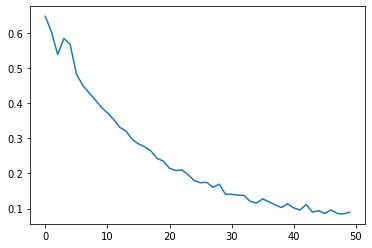

In [0]:
a=model.history.history['loss']
#a.sort()
#a=a[::-1]

plt.plot(a)
plt.show()